In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date



'2017-08-23'

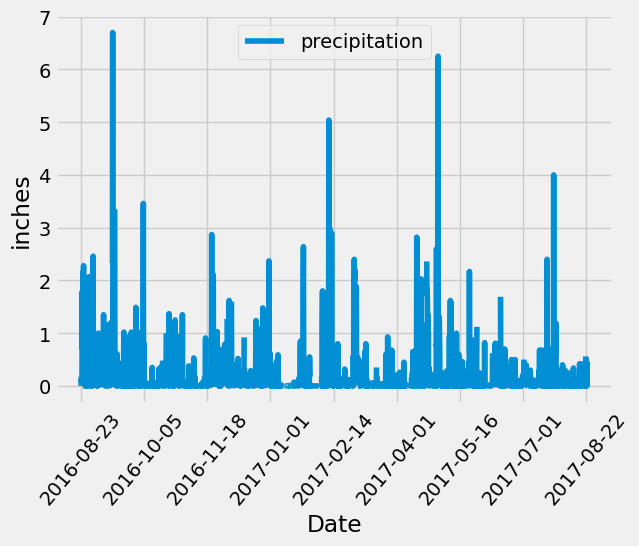

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= one_year_ago_str)\
    .filter(measurement.date <= most_recent_date)\
    .order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index('date', inplace=True)

# Plotting with Pandas and Matplotlib
ax = precipitation_df.plot(rot=50)

# Adjusting x-axis ticks
num_ticks = 9
tick_positions = range(0, len(precipitation_df.index), len(precipitation_df.index) // (num_ticks - 1))
tick_labels = [precipitation_df.index[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels)

plt.xlabel('Date')
plt.ylabel('inches')


plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate summary statistics for precipitation data
summary_stats = precipitation_df['precipitation'].describe()
summary_stats_df = pd.DataFrame(summary_stats)
# Print the summary statistics
summary_stats_df


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.id)).scalar()
total_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station))\
                         .group_by(measurement.station)\
                         .order_by(func.count(measurement.station).desc())\
                         .all()

# Print the results
for station, count in active_stations:
    print ({station},{count})

{'USC00519281'} {2772}
{'USC00519397'} {2724}
{'USC00513117'} {2709}
{'USC00519523'} {2669}
{'USC00516128'} {2612}
{'USC00514830'} {2202}
{'USC00511918'} {1979}
{'USC00517948'} {1372}
{'USC00518838'} {511}


In [44]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = session.query(measurement.station,func.count(measurement.id))\
                      .group_by(measurement.station)\
                      .order_by(func.count(measurement.station).desc())\
                      .first()[0]



tem_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
                    .filter(measurement.station == most_active_station)\
                    .all()

min_temp, max_temp, avg_temp = tem_stats[0]

print(min_temp, max_temp, avg_temp)



54.0 85.0 71.66378066378067


Text(0.5, 4.183333333333314, 'Temperature')

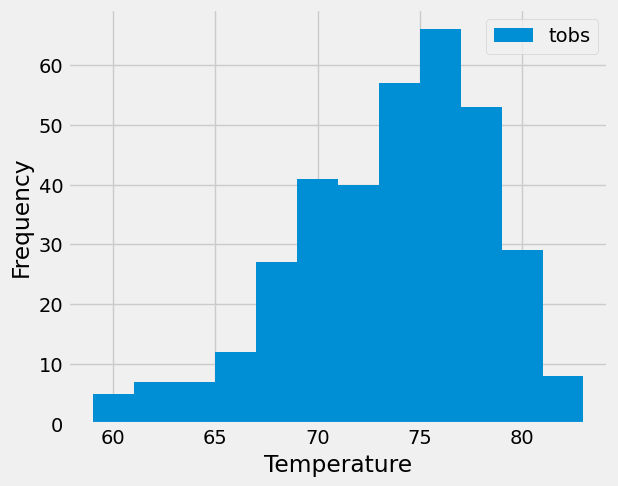

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the most active station ID within the last year
data = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= one_year_ago_str).all() 

df = pd.DataFrame(data, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")

# Close Session

In [47]:
# Close Session
session.close()